# Сборный проект

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.  

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных

*Name* — название игры  

*Platform* — платформа  

*Year_of_Release* — год выпуска

*Genre* — жанр игры

*NA_sales* — продажи в Северной Америке (миллионы проданных копий)

*EU_sales* — продажи в Европе (миллионы проданных копий)

*JP_sales* — продажи в Японии (миллионы проданных копий)

*Other_sales* — продажи в других странах (миллионы проданных копий)

*Critic_Score* — оценка критиков (максимум 100)

*User_Score* — оценка пользователей (максимум 10)

*Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

# План работы

**Шаг 1. Открытие файла с данными и изучение общей информации  
Шаг 2. Подготовка данных  
Шаг 3. Проведение исследовательского анализа данных  
Шаг 4. Составление портрета пользователя каждого региона  
Шаг 5. Проверка гипотез**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Открытие файла с данными и изучение общей информации

In [2]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
display(games.head())
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод раздела:** в данных присутствуют пропущенные значения, так же не все столбцы соответствуют нужному типу данных.

## Шаг 2. Подготовка данных

### Проверка на явные и неявные дубликаты

In [3]:
print(f'Число явных дубликатов в талице: {games.duplicated().sum()}')
duplicate = games[['Name', 'Platform', 'Year_of_Release']].duplicated().sum()
print(f'Число неявных дубликатов в 3 столбцах: {duplicate}')

Число явных дубликатов в талице: 0
Число неявных дубликатов в 3 столбцах: 2


Дублированные строки можно удалить, их количество не повлияет на анализ.

In [4]:
#удаление неявных дубликатов и проверка на их остаток
games = games.drop_duplicates(subset=['Name', 'Platform', 'Year_of_Release'])
after_duplicate = games[['Name', 'Platform', 'Year_of_Release']].duplicated().sum()
print(f'Число неявных дубликатов в 3 столбцах после обработки: {after_duplicate}')

Число неявных дубликатов в 3 столбцах после обработки: 0


### Приведение к нижнему регистру всех названий столбцов

In [5]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Изменение типов данных столбцов, удаление пропущенных значений и вставление заглушек

In [6]:
games.year_of_release = games.year_of_release.astype('Int64')
games.user_score = pd.to_numeric(games.user_score, errors='coerce')
games = games.dropna(subset=['name', 'year_of_release']).reset_index(drop=True)
games.loc[games['rating'].isna(), 'rating'] = 'Nan'
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


В столбце года выпуска, где значение подразумевают целое число, я изменил на int, для того чтобы датафрейм занимал меньше места. В столбце оценки пользователей привел к дробному типу, для удобства анализа.

По моему мнению нельзя заменять некоторые пропущенные значения в этой таблице. В столбце с названиями игр находятся уникальные значения. Год релиза и жанр для каждой игры свой и я не могу ему присвоить случайное значение. Что касется оценок критиков и пользователей, то оставил пропущенные  значения, ибо их нельзя заполнять. Значение tbd(будет определено) в столбце с оценками пользователй решил заменить на пустые значения. 

Полагаю, что пропуски в названии могли возникунть из-за иностранного названия игры, что привело к трудностям с переводом. Оценки пользователей и критиков, из-за недавнего выхода игр, и игроки, и критики не успели их оценить. Также это могут быть очень старые игры, которые были популярны давно, когда не существовало общепризнанных форумов для оценок. Возможно об источнике, откуда взяты оценки, пользователи некотрых игр попросту не знают. Проблемы могли возникнуть на этапе загрузки и на этапе выгрузки данных. Неправильный запрос, объединение таблиц также может быть причиной.

### Добавление нового стлобца с суммой всех продаж

In [7]:
games['total_sales'] = games.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Nan,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Nan,31.38


**Вывод раздела:** в ходе предобработки данных были выявлены и обработаны: неявные дубликаты, несоответствия столбцов должному типу данных, пропущенные значения. Ко всему прочему добвлен столбец.

## Шаг 3. Проведение исследовательского анализа данных

### Какое количество игр выпускалось в разные годы?

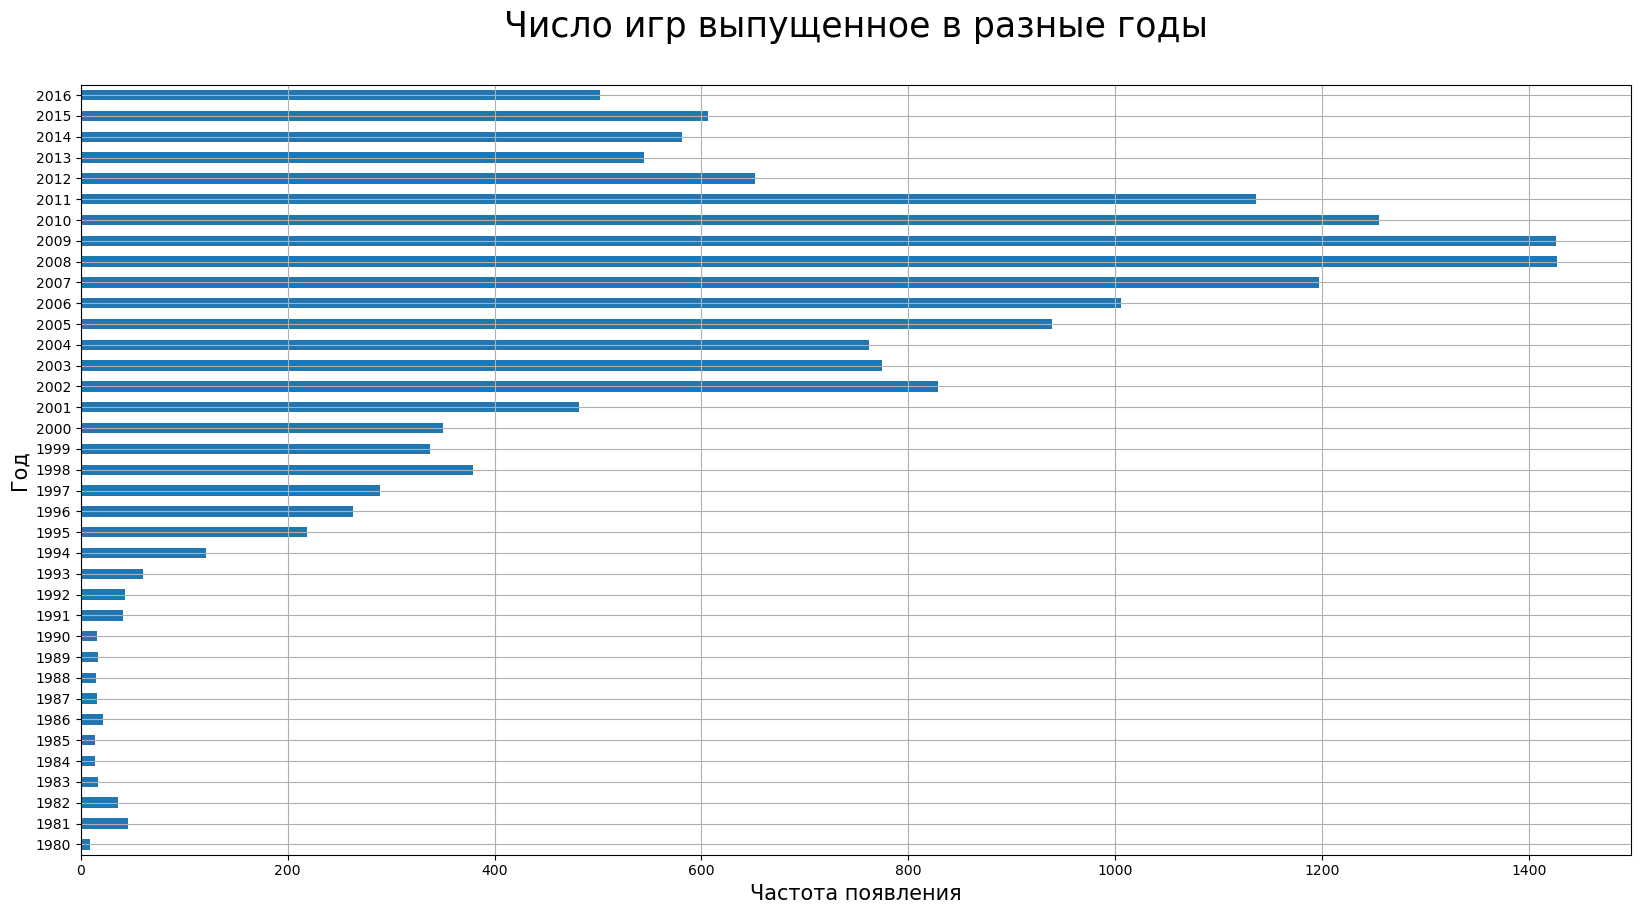

In [8]:
# составил сводную таблицу и построил по ней столбчатый график
(
    games.pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Число игр выпущенное в разные годы' + "\n", fontsize = 25)
);
plt.ylabel('Год', fontsize = 15);
plt.xlabel('Частота появления', fontsize = 15);

**Вывод:** данные до 1994 включительно года не важны

### Как менялись общие продажи относительно платформ?

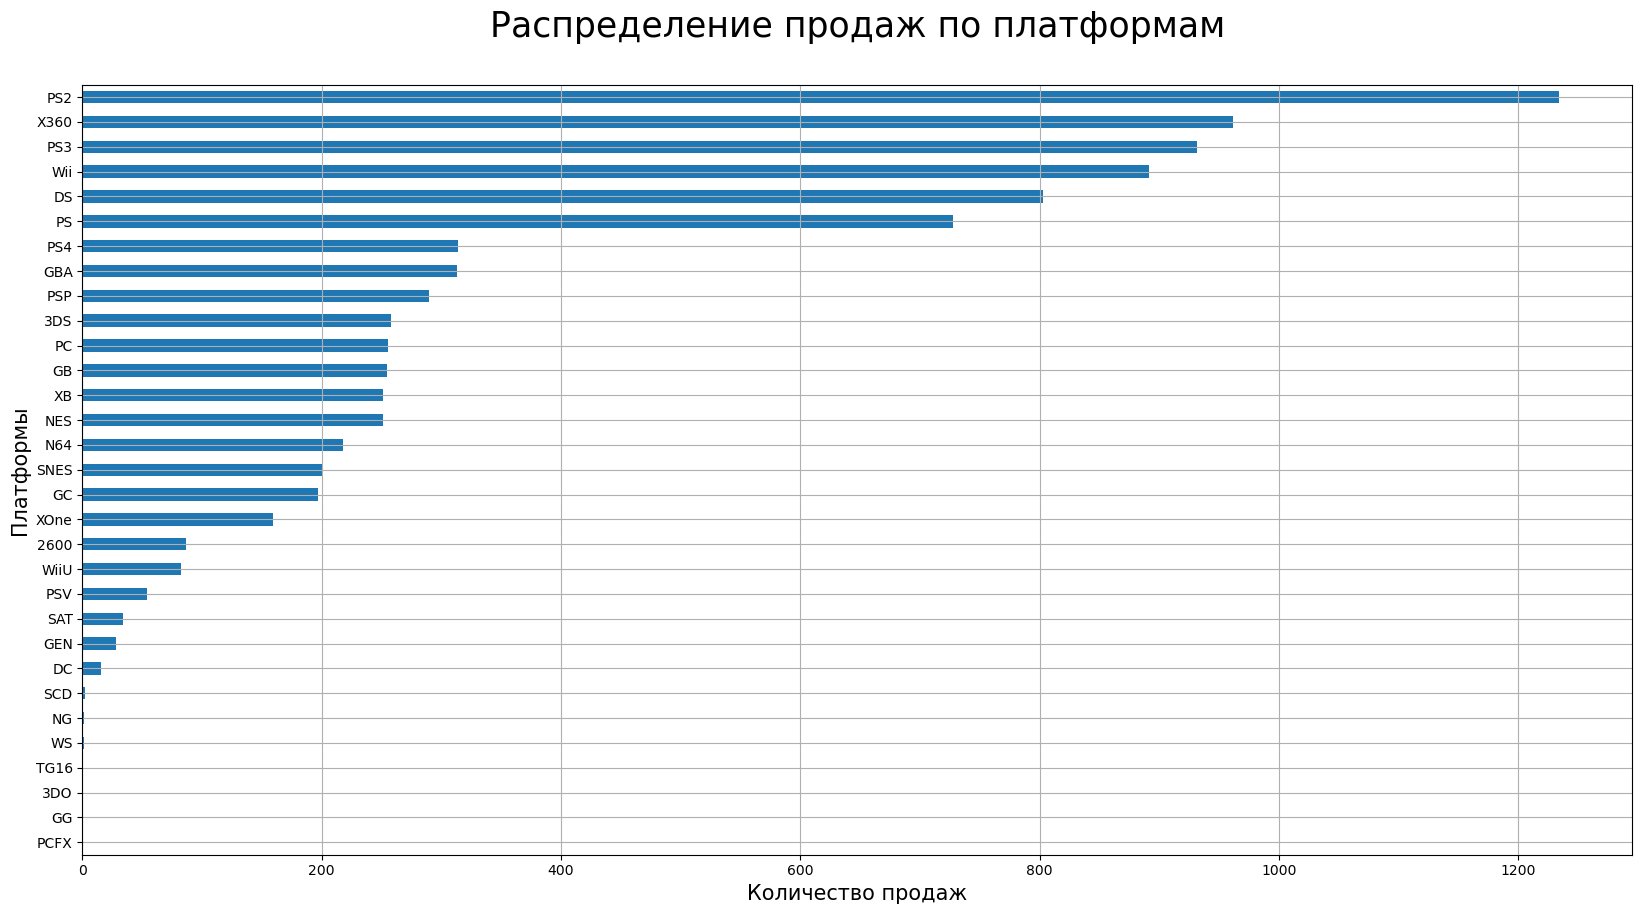

In [9]:
# составил сводную таблицу и построил по ней столбчатый график
(
    games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Распределение продаж по платформам' + "\n", fontsize = 25)
);
plt.ylabel('Платформы', fontsize = 15);
plt.xlabel('Количество продаж', fontsize = 15);

**Вывод:** наибольшие продажи у следующих платформ: PS, DS, Wii, PS3, X360, PS2.

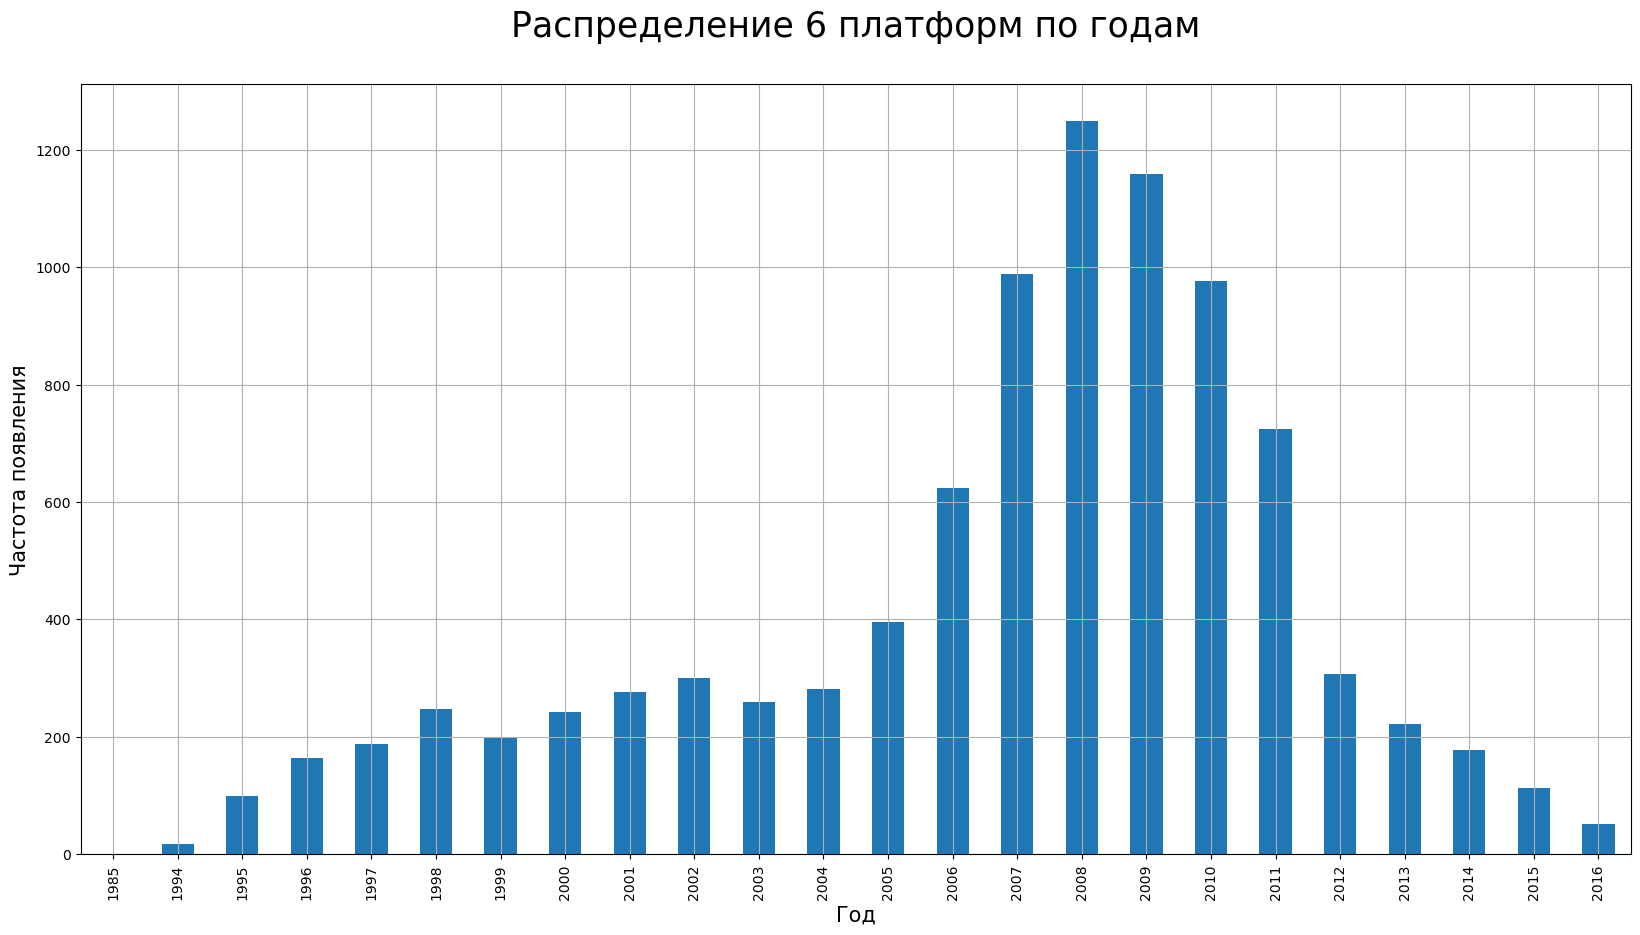

In [10]:
# составил сводную таблицу отфильтрованную для определённых плтаформ и построил по ней столбчатый график
(
    games.query('platform in ["PS", "DS", "Wii", "PS3", "X360", "PS2"]')
    .pivot_table(index='year_of_release', values='platform', aggfunc='count')
    .plot(kind = 'bar', grid=True, figsize=(20, 10), legend=False)
    .set_title('Распределение 6 платформ по годам' + "\n", fontsize = 25)
);
plt.ylabel('Частота появления', fontsize = 15);
plt.xlabel('Год', fontsize = 15);

In [11]:
time_life = games.pivot_table(index='platform', values='year_of_release'
                              , aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min']
int(time_life.life.median())

6

**Вывод:** характерный срок для появления новой и исчезновения старой платформы составляет 6 лет. Актуальный период с 2012 по 2016 года.

### Какие платформы лидируют по продажам в актульный период?

In [12]:
# создал новый датафрейм из старого, включив в него определённые года и изменил индексацию
current_period = games.query('year_of_release in [2012, 2013, 2014, 2015, 2016]').reset_index(drop=True)
current_period.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Nan,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Nan,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
5,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
6,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
7,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Nan,11.68
8,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
9,New Super Mario Bros. 2,3DS,2012,Platform,3.66,3.14,2.47,0.63,78.0,7.2,E,9.90


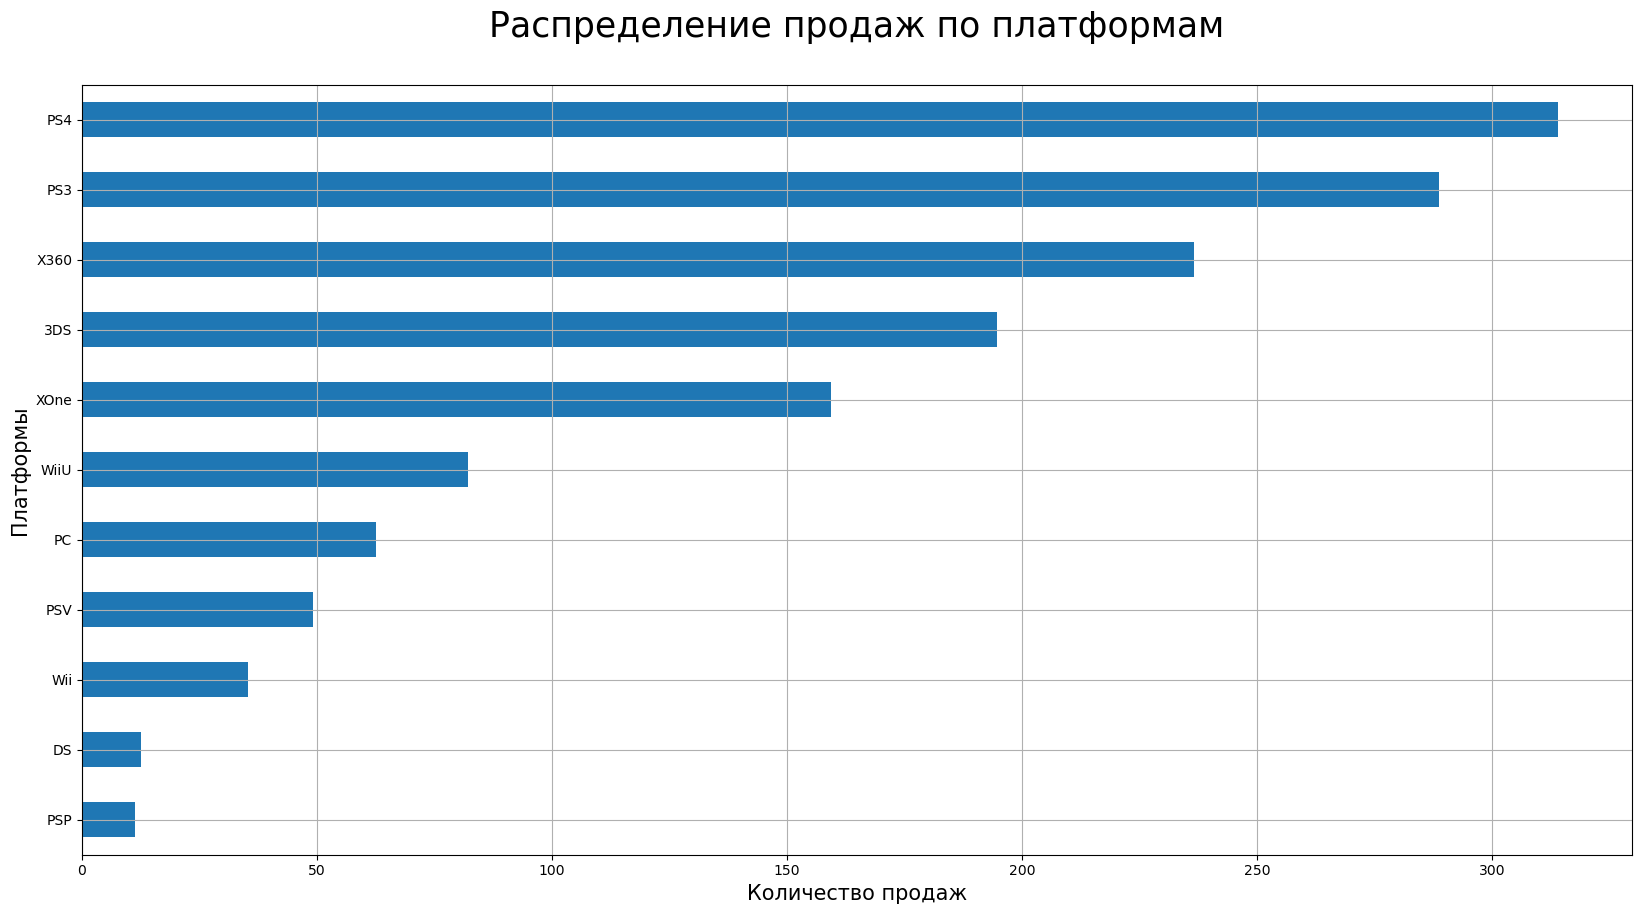

In [13]:
# составил сводную таблицу и построил по ней столбчатый график
(
    current_period.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Распределение продаж по платформам' + "\n", fontsize = 25)
);
plt.ylabel('Платформы', fontsize = 15);
plt.xlabel('Количество продаж', fontsize = 15);

**Вывод:** лидируют по продажам такие платформы, как PS4, PS3. Проваливаются в продажах: DC, PSP. Потенциально прибыльные платформы: PS4, PS3, X360, 3DS и XOne

### Как распределяются глобальные продажи в разбивке по платформам?

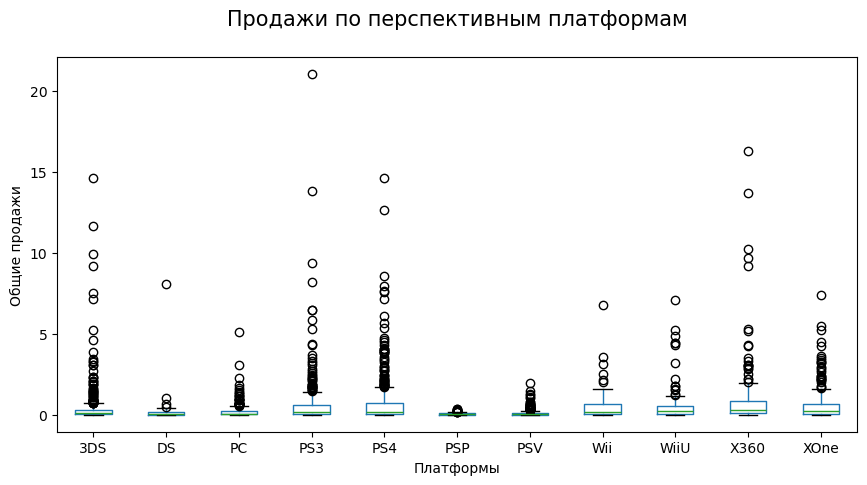

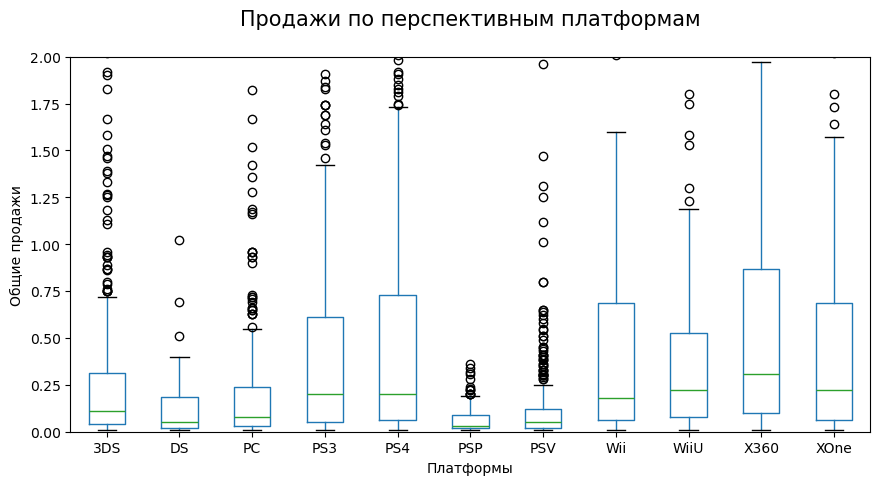

In [14]:
# построил два графика "ящик с усами" от нового датафрейма
(
    current_period
    .boxplot(column='total_sales', by='platform', figsize=(10, 5), grid=False)
    .set_title('Продажи по перспективным платформам' + "\n", fontsize = 15)
);
plt.suptitle('');
plt.xlabel('Платформы', fontsize = 10);
plt.ylabel('Общие продажи', fontsize = 10);

(
    current_period
    .boxplot(column='total_sales', by='platform', figsize=(10, 5), grid=False)
    .set_title('Продажи по перспективным платформам' + "\n", fontsize = 15)
);
plt.suptitle('');
plt.xlabel('Платформы', fontsize = 10);
plt.ylabel('Общие продажи', fontsize = 10);
plt.ylim(0, 2);

**Вывод:** топы платформ по суммарным продажам и глобальным различаются. Обнаружено множество выросов. Крупные медианные продажи у платформ X360, Wii, PS4, XOne и WiiU.

### Как влияют на продажи внутри платформ отзывы пользователей и критиков?

Коэффицент корреляции между оценками пользователей и общим числом продаж: -0.031957110204556376


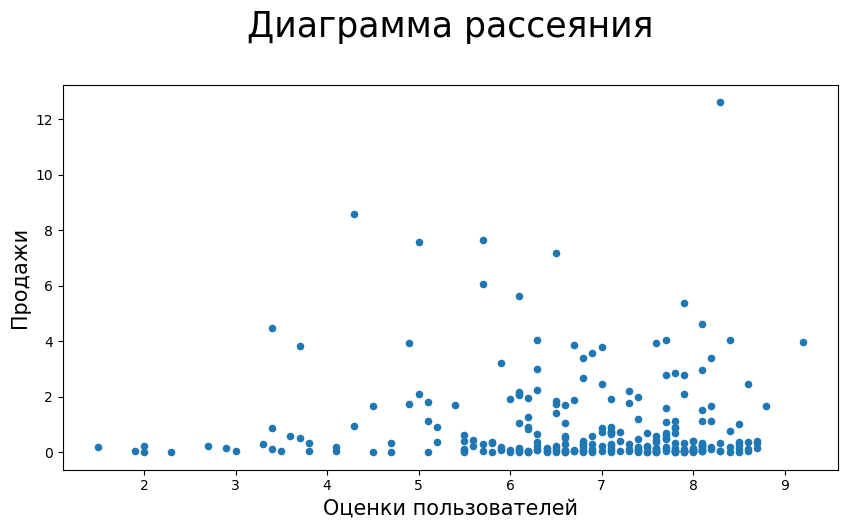

In [15]:
# отфильтровал датафрейм и построил по нему диаграмму рассеяния 
(
    current_period.query('platform == "PS4"')
    .plot.scatter(x='user_score', y='total_sales', figsize=(10, 5))
    .set_title('Диаграмма рассеяния' + "\n", fontsize = 25)
);
plt.ylabel('Продажи', fontsize = 15);
plt.xlabel('Оценки пользователей', fontsize = 15);
# посчитал коэффицент корреляции
corr_ut = current_period.query('platform == "PS4"').user_score.corr(current_period.query('platform == "PS4"').total_sales)
print(f'Коэффицент корреляции между оценками пользователей и общим числом продаж: {corr_ut}')

Коэффицент корреляции между оценками критиков и общим числом продаж: 0.40656790206178095


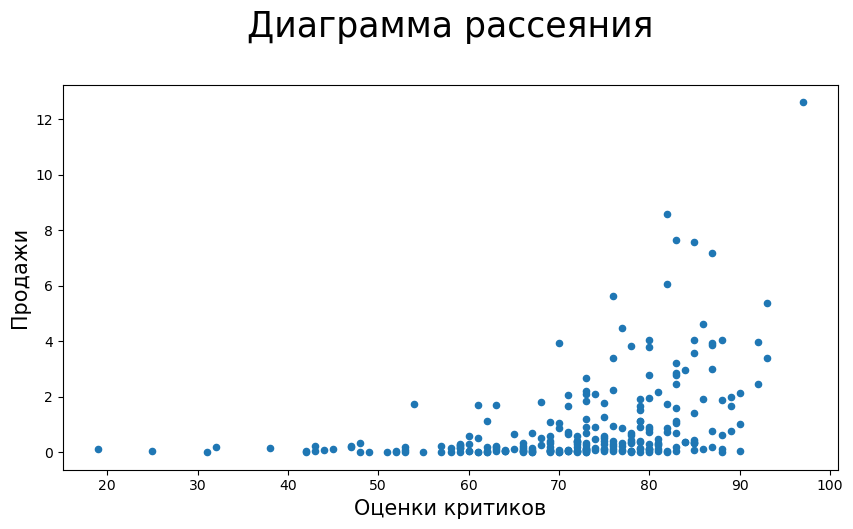

In [16]:
# отфильтровал датафрейм и построил по нему диаграмму рассеяния 
(
    current_period.query('platform == "PS4"')
    .plot.scatter(x='critic_score', y='total_sales', figsize=(10, 5))
    .set_title('Диаграмма рассеяния' + "\n", fontsize = 25)
);
plt.ylabel('Продажи', fontsize = 15);
plt.xlabel('Оценки критиков', fontsize = 15);
# посчитал коэффицент корреляции
corr_ct = current_period.query('platform == "PS4"').critic_score.corr(current_period.query('platform == "PS4"').total_sales)
print(f'Коэффицент корреляции между оценками критиков и общим числом продаж: {corr_ct}')

**Вывод:** взаимосвязь между оценками пользователей и числом продаж очень незкая, можно даже сказать что её нет, а критиков выше, но всё равно не слишком сильная. Тем не менее, число продаж зависит от оценок критиков, нежели оценкок пользователей.

Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы X360: 0.01, 0.36


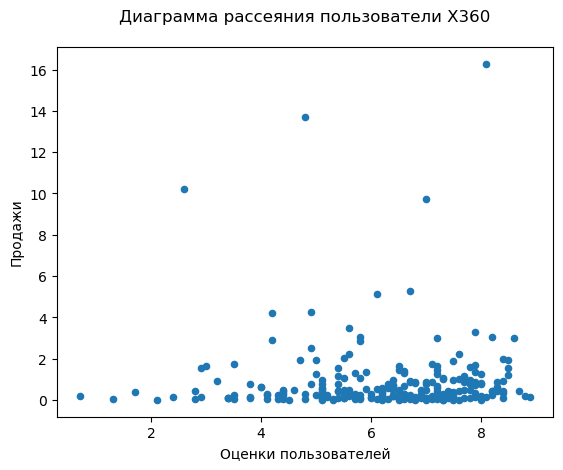

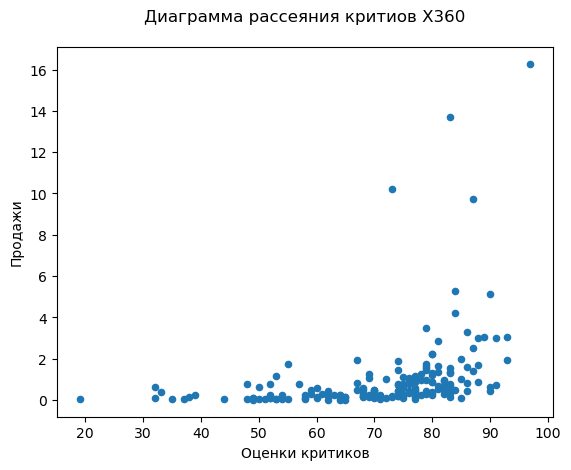

Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы XOne: -0.07, 0.42


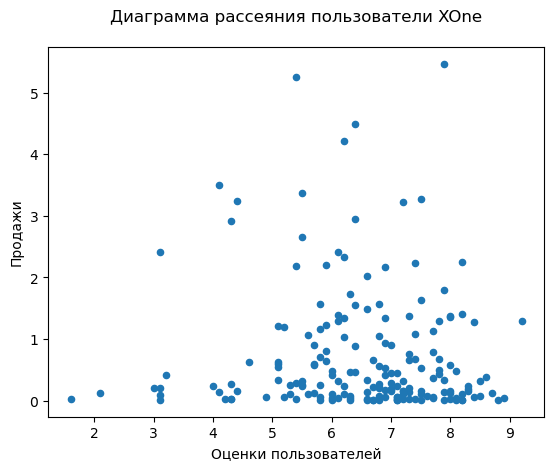

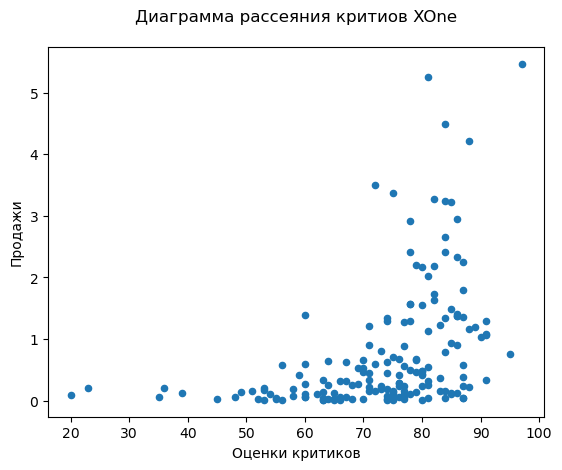

Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы PS3: -0.01, 0.33


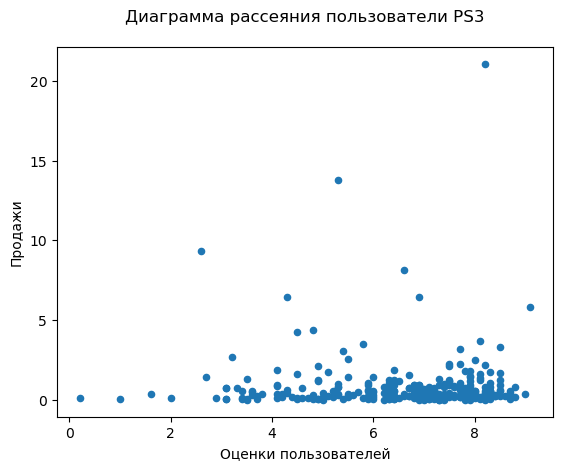

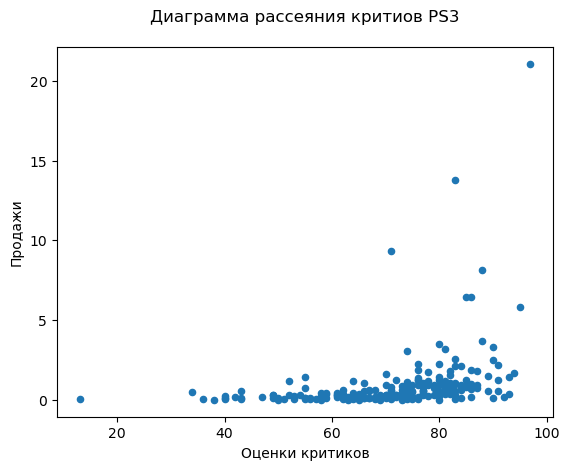

Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы 3DS: 0.2, 0.32


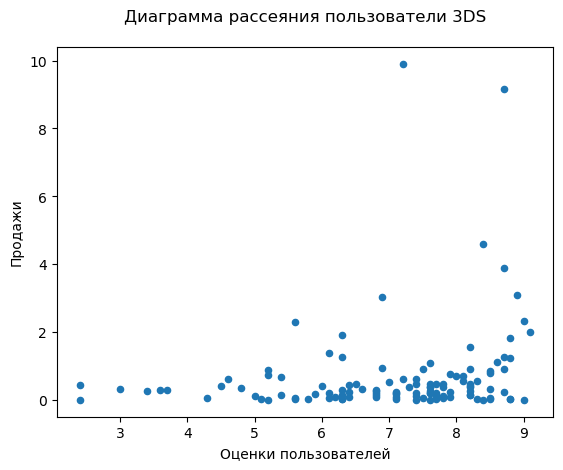

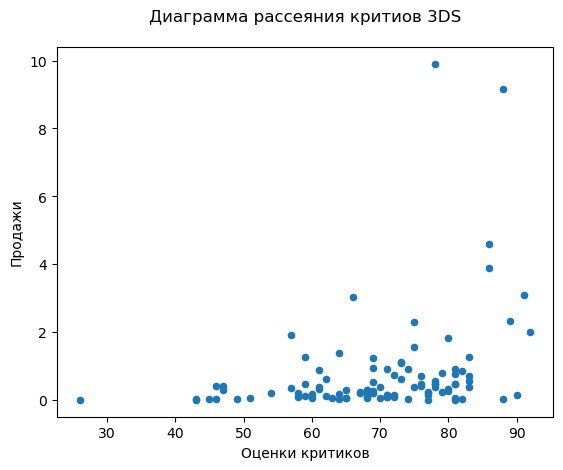

Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы PC: -0.12, 0.24


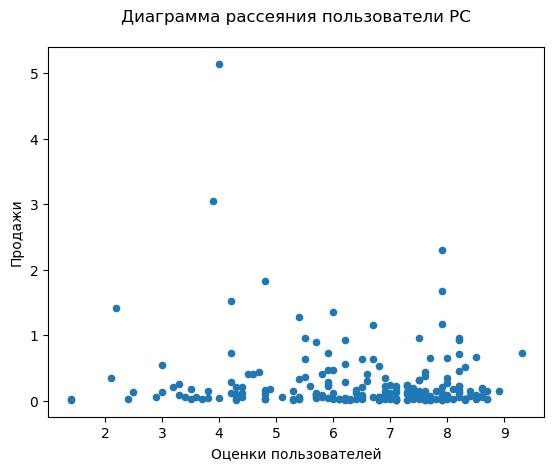

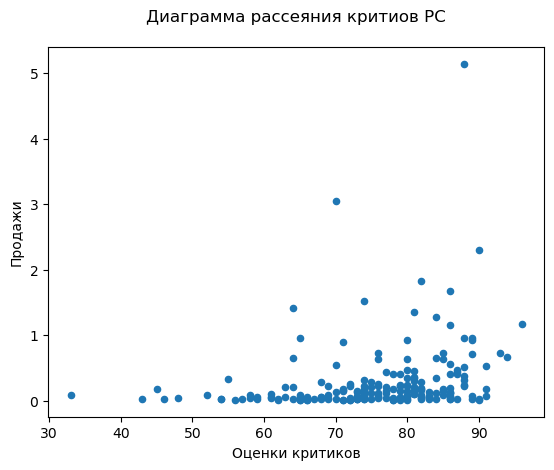

In [17]:
# создал цикл, в котором на каждом шаге высчитывается коэффиценты корреляций 
# и выводится 2 графика от отфильтрованных датафреймов
for plot in ['X360', 'XOne', 'PS3', '3DS', 'PC']:
    corr_ut = current_period.loc[current_period.platform == plot] \
    .user_score.corr(current_period.loc[current_period.platform == plot].total_sales)
    corr_ct = current_period.loc[current_period.platform == plot] \
    .critic_score.corr(current_period.loc[current_period.platform == plot].total_sales)
    (
        current_period.loc[current_period.platform == plot]
        .plot.scatter(x='user_score', y='total_sales')
        .set_title(f'Диаграмма рассеяния пользователи {plot}' + "\n")
    );
    plt.ylabel('Продажи');
    plt.xlabel('Оценки пользователей');
    (
        current_period.loc[current_period.platform == plot] 
        .plot.scatter(x='critic_score', y='total_sales')
        .set_title(f'Диаграмма рассеяния критиов {plot}' + "\n")
    );
    plt.ylabel('Продажи');
    plt.xlabel('Оценки критиков');
    print('Коэффицент корреляции между оценками пользователей, критиков и общим числом продаж для платформы'
          , f'{plot}: {round(corr_ut,2)}, {round(corr_ct,2)}')
    plt.show()

**Вывод:** примерно такие же взаимосвязи как и у платформы PS4 и у других платформ.

### Как выглядит общее распределение игр по жанрам?

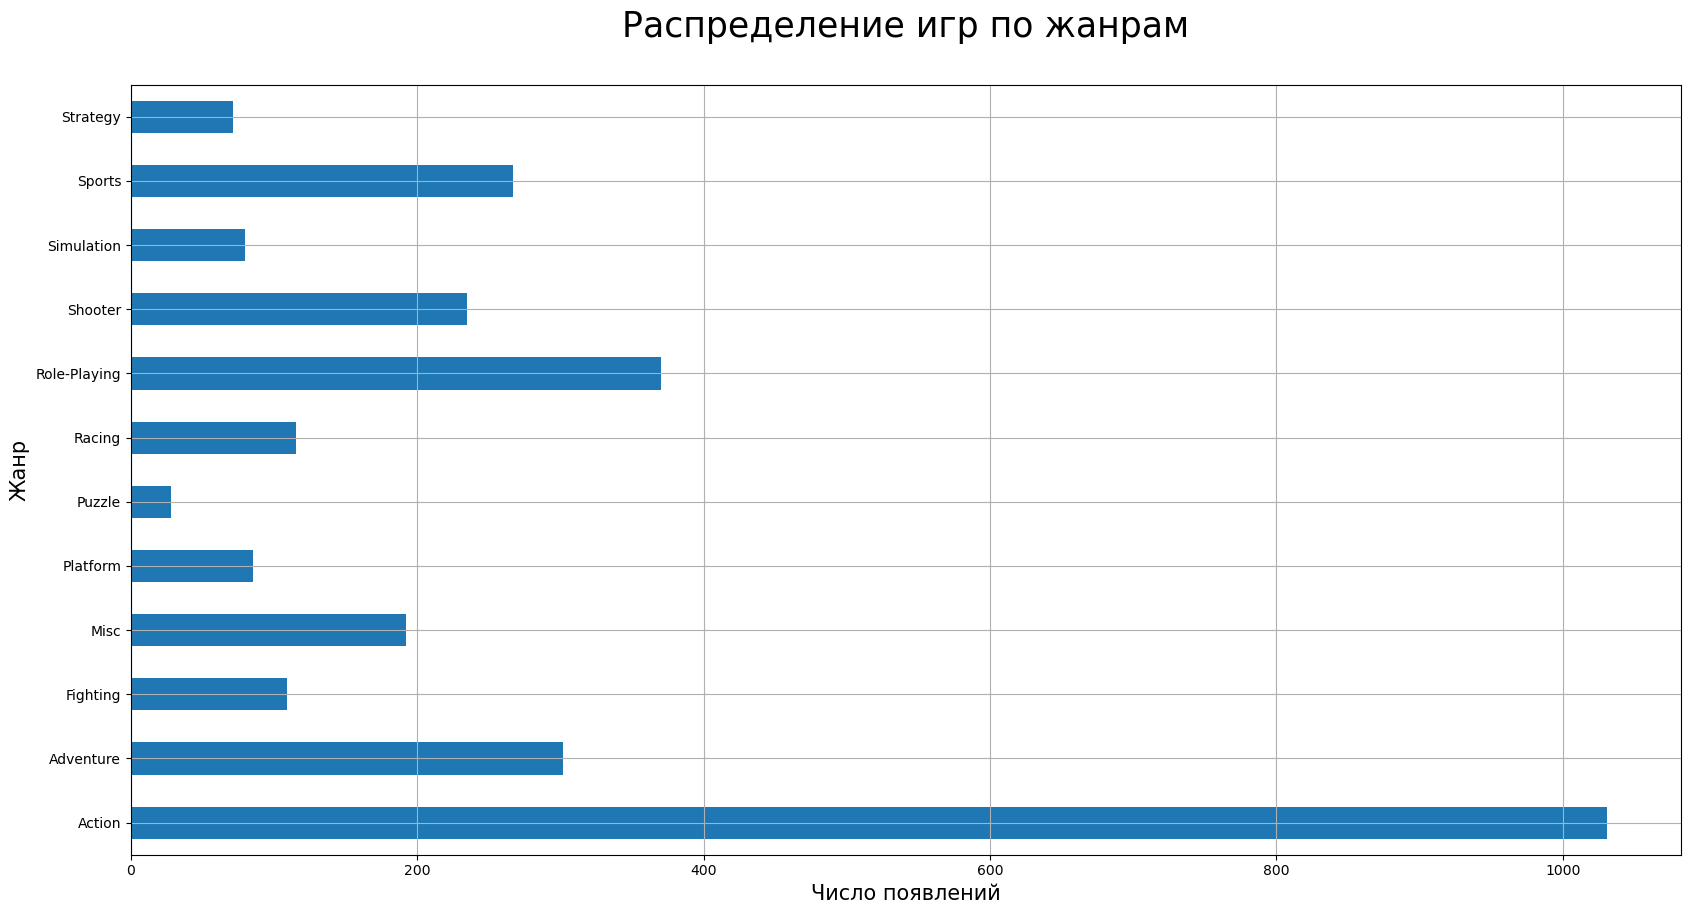

In [18]:
# создал сводную таблицу и  по ней построил столбчатый график
(
    current_period.pivot_table(index='genre', values='name', aggfunc='count')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Распределение игр по жанрам' + "\n", fontsize = 25)
);
plt.ylabel('Жанр', fontsize = 15);
plt.xlabel('Число появлений', fontsize = 15);

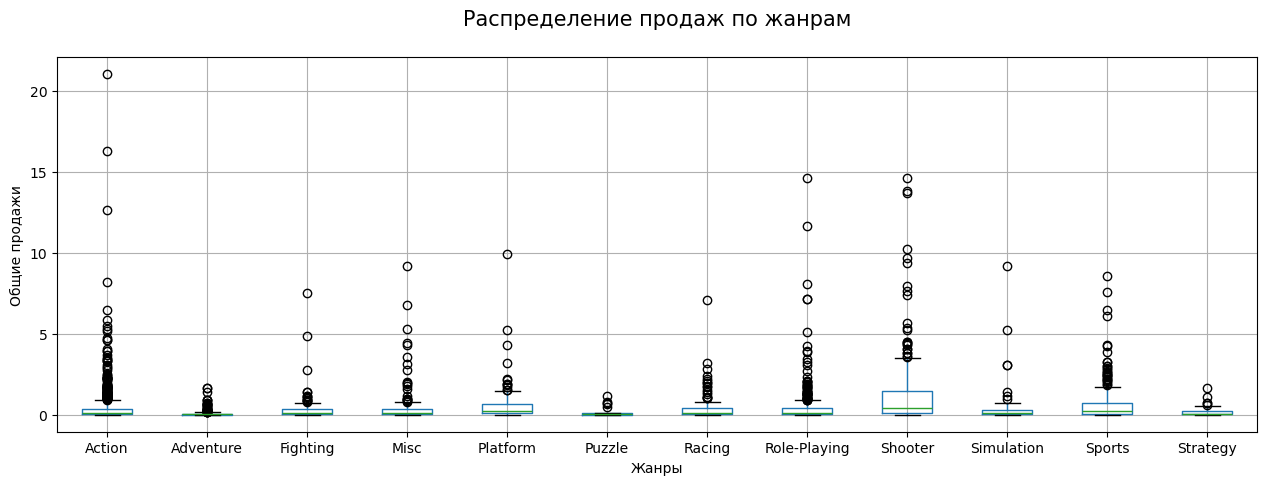

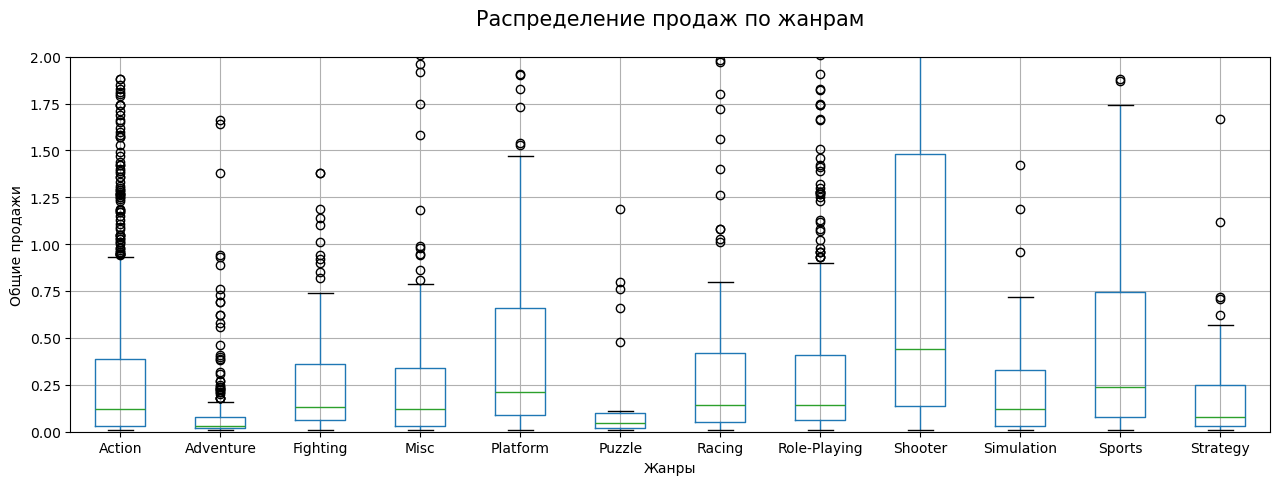

In [19]:
# построил два графика "ящик с усами". Во втором ограничил значения по иксу.
(
    current_period
    .boxplot(column='total_sales', by='genre', figsize=(15, 5))
    .set_title('Распределение продаж по жанрам' + "\n", fontsize = 15)
);
plt.suptitle('');
plt.xlabel('Жанры', fontsize = 10);
plt.ylabel('Общие продажи', fontsize = 10);
(
    current_period
    .boxplot(column='total_sales', by='genre', figsize=(15, 5))
    .set_title('Распределение продаж по жанрам' + "\n", fontsize = 15)
);
plt.suptitle('');
plt.xlabel('Жанры', fontsize = 10);
plt.ylabel('Общие продажи', fontsize = 10);
plt.ylim(0, 2);

**Вывод:** самыми прибильными жанрами являются: Shooter, Sports и Platform, принимая во внимания, то что в этих жанрах выпущено не так много игр, например, как в Action и Role-Playing. Выделяется жанр Adventure, у которого досточно большое число выпущенных в нём игр, но продажи совсем маленькие.

**Вывод раздела:** в ходе проведения исследования было осуществлено определение: несущественного периода, наибольших продаж у платформ, характерный срок для появления новой и исчезновения старой платформы, актуального периода, лидирующие и провалившиеся по продажам платформы, потенциально прибыльные платформы, взаимосвязи между оценками пользователей и числом продаж по платформам, самые прибыльные жанры.

## Шаг 4. Составление портрета пользователя каждого региона

### Какие самые популярные платформы для пользователя каждого региона?

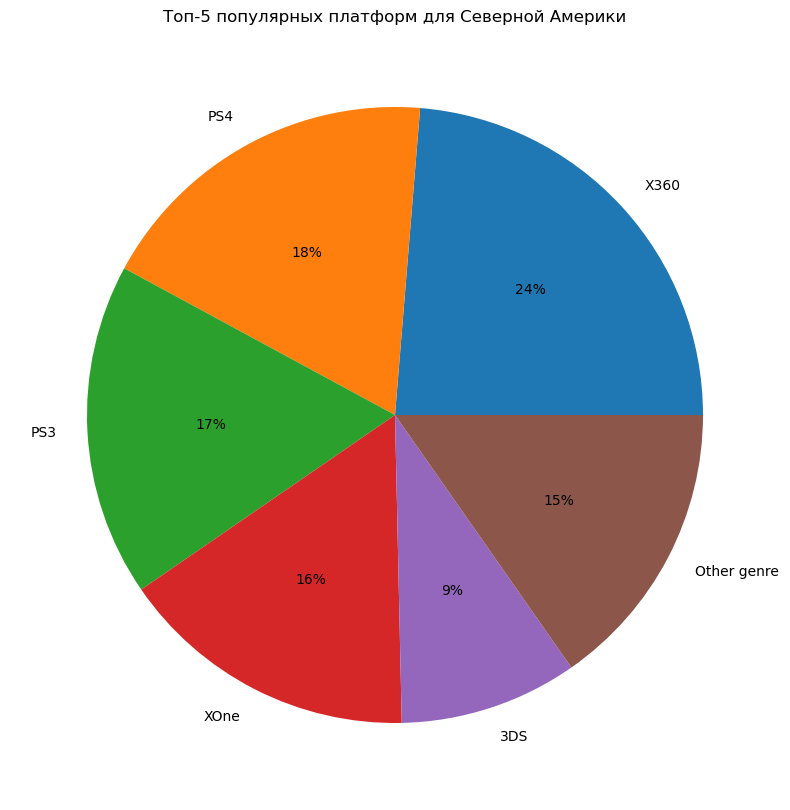

In [20]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
na = (
    current_period.pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na.loc['Other genre', 'na_sales'] = sum(na.loc['WiiU':'PSP', 'na_sales'])
na = na.drop(na.loc['WiiU':'PSP'].index)
(na.plot(kind = 'pie', y='na_sales', legend=False, autopct='%1.0f%%', 
         figsize=(20,10), title='Топ-5 популярных платформ для Северной Америки')
);
plt.ylabel('');

In [21]:
na = (
    current_period.pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31
WiiU,38.10
PC,19.12
Wii,17.45
PSV,10.98


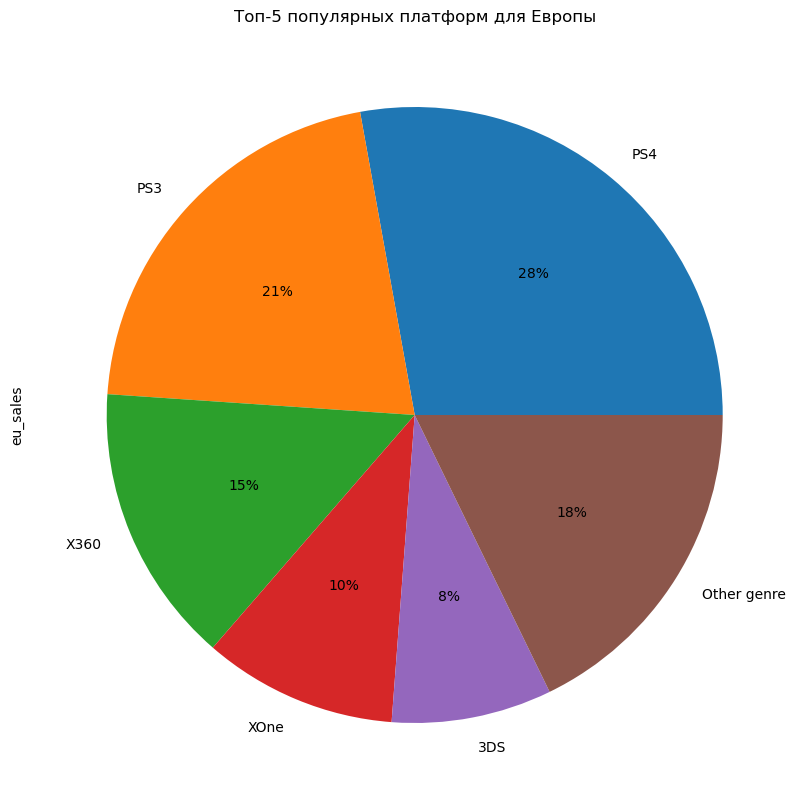

In [22]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
eu = (
    current_period.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
eu.loc['Other genre', 'eu_sales'] = sum(eu.loc['PC':'PSP', 'eu_sales'])
eu = eu.drop(eu.loc['PC':'PSP'].index)
(eu.plot(kind = 'pie', y='eu_sales', 
          legend=False, autopct='%1.0f%%', 
          figsize=(20,10), title='Топ-5 популярных платформ для Европы')
);

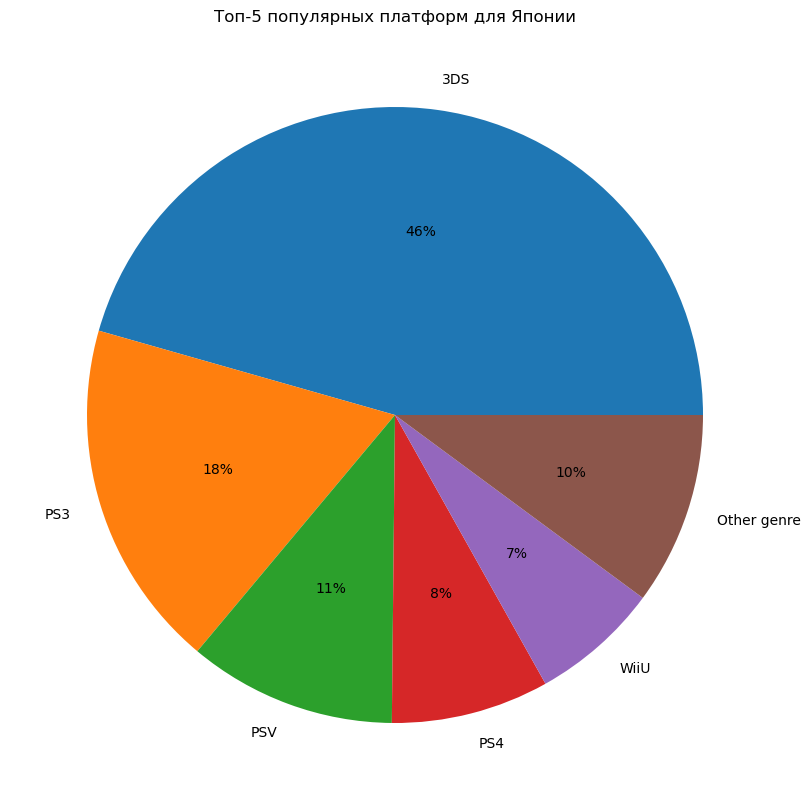

In [23]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
jp = (
    current_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
jp.loc['Other genre', 'jp_sales'] = sum(jp.loc['PSP':'PC', 'jp_sales'])
jp = jp.drop(jp.loc['PSP':'PC'].index)
(jp.plot(kind = 'pie', y='jp_sales', 
          legend=False, autopct='%1.0f%%', 
          figsize=(20,10), title='Топ-5 популярных платформ для Японии')
);
plt.ylabel('');

**Вывод:** в северной Америке рынок почти поровну делят платформы X360, PS4, PS3 и XOne. В Европе преобладает PS4, в меньшей степени PS3 и X360. В Японии около половиины занимает 3DS, на втором месте PS3.

### Какие самые популярные жанры для пользователя каждого региона?

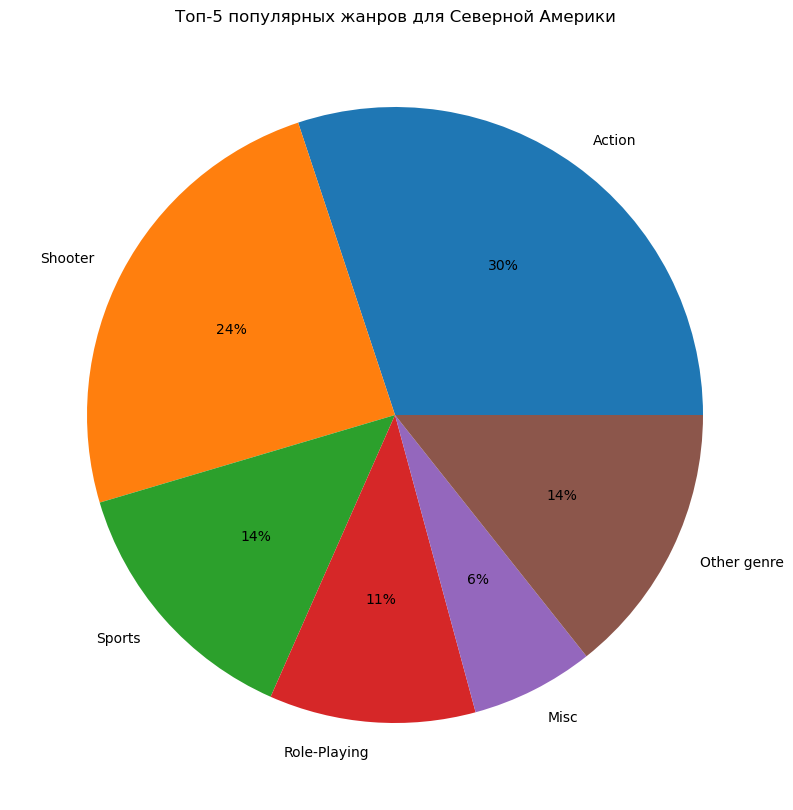

In [24]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
na_genre = (
    current_period.pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na_genre.loc['Other genre', 'na_sales'] = sum(na_genre.loc['Platform':'Puzzle', 'na_sales'])
na_genre = na_genre.drop(na_genre.loc['Platform':'Puzzle'].index)
(na_genre.plot(kind = 'pie', y='na_sales', 
          legend=False, autopct='%1.0f%%', 
          figsize=(20,10), title='Топ-5 популярных жанров для Северной Америки')
);
plt.ylabel('');

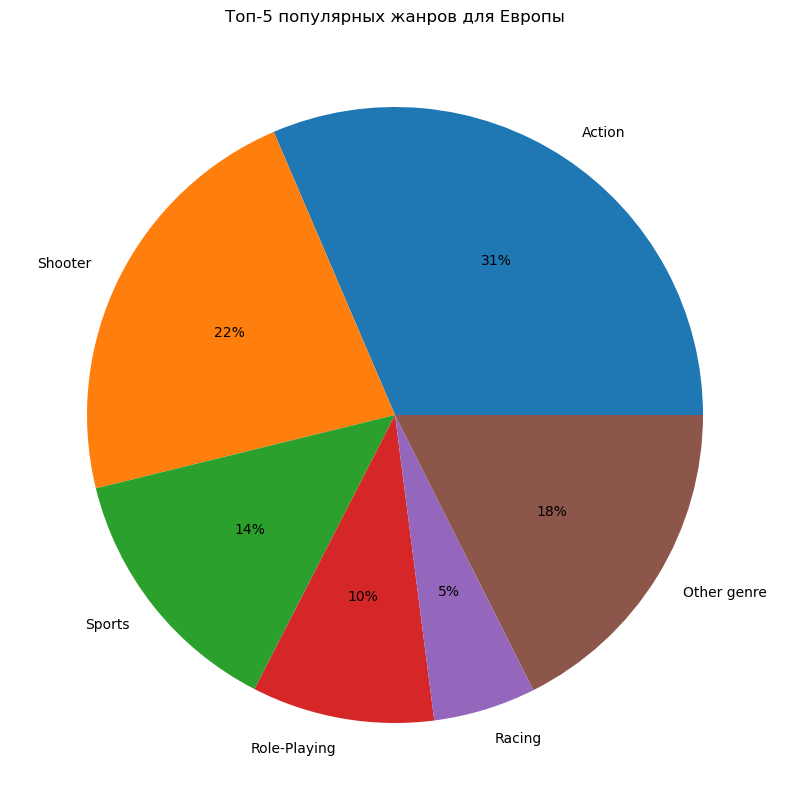

In [25]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
eu_genre = (
    current_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
eu_genre.loc['Other genre', 'eu_sales'] = sum(eu_genre.loc['Misc':'Puzzle', 'eu_sales'])
eu_genre = eu_genre.drop(eu_genre.loc['Misc':'Puzzle'].index)
(eu_genre.plot(kind = 'pie', y='eu_sales', 
          legend=False, autopct='%1.0f%%', 
          figsize=(20,10), title='Топ-5 популярных жанров для Европы')
);
plt.ylabel('');

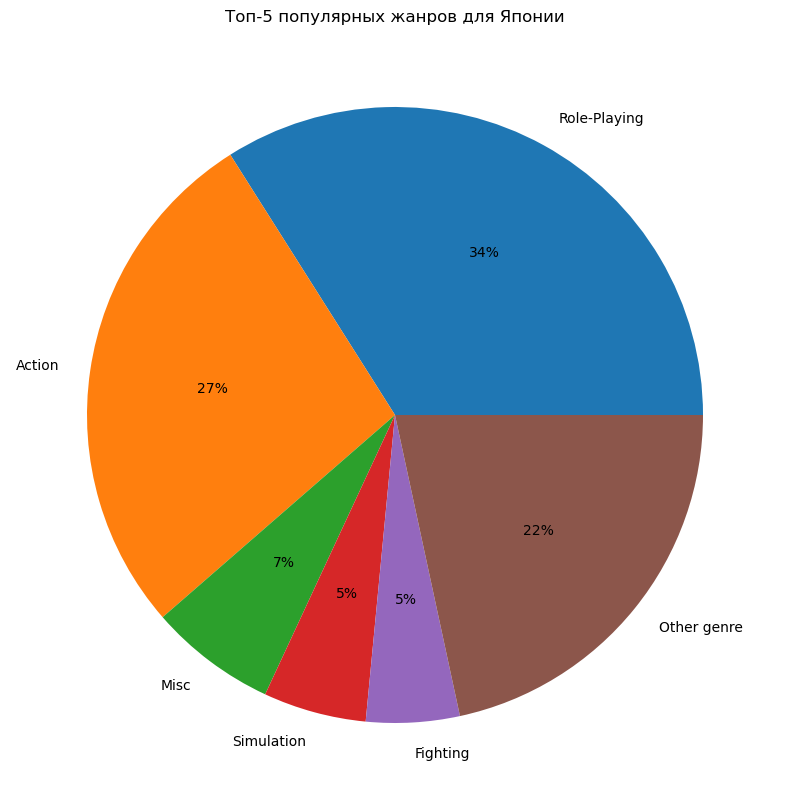

In [26]:
# создал отсортированную сводную таблицу, добавил в неё новую строку и удалил ненужные строки. 
#Построил круговую диаграмму.
jp_genre = (
    current_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
jp_genre.loc['Other genre', 'jp_sales'] = sum(jp_genre.loc['Shooter':'Puzzle', 'jp_sales'])
jp_genre = jp_genre.drop(jp_genre.loc['Shooter':'Puzzle'].index)
(jp_genre.plot(kind = 'pie', y='jp_sales', 
          legend=False, autopct='%1.0f%%', 
          figsize=(20,10), title='Топ-5 популярных жанров для Японии')
);
plt.ylabel('');

**Вывод:** в Северной Америке, как и в Европе самые популярные Action и Shooter. В Японии Role-Playing и Action.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

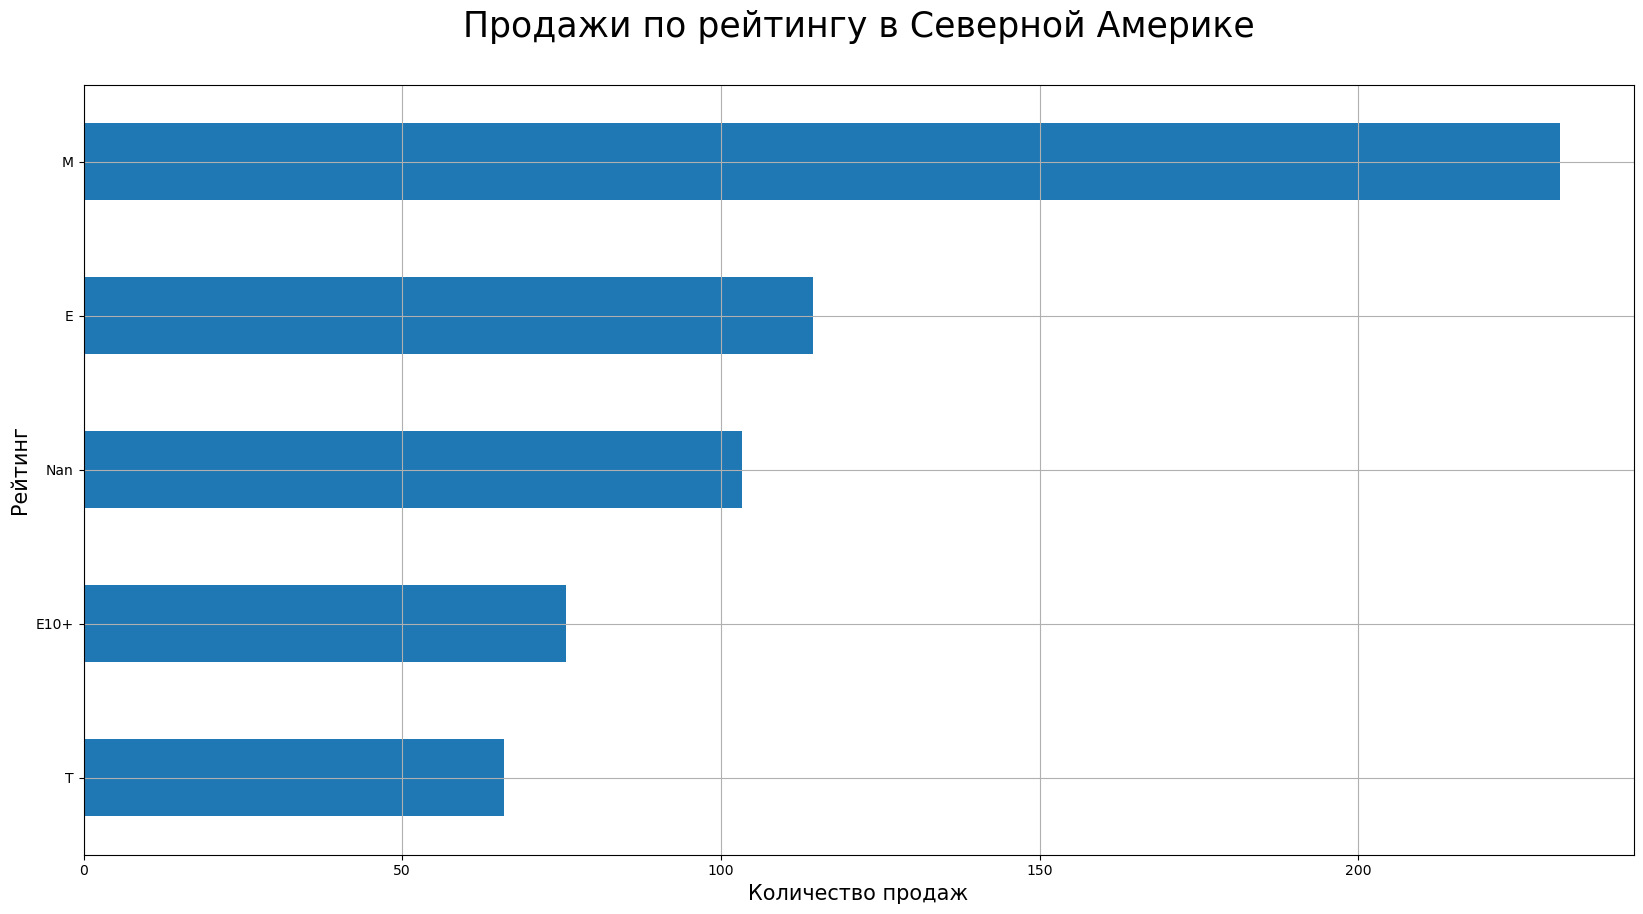

In [27]:
# создал сводную таблицу и построил по ней столбчатую диграмму
(
    current_period.pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Продажи по рейтингу в Северной Америке' + "\n", fontsize = 25)
);
plt.ylabel('Рейтинг', fontsize = 15);
plt.xlabel('Количество продаж', fontsize = 15);

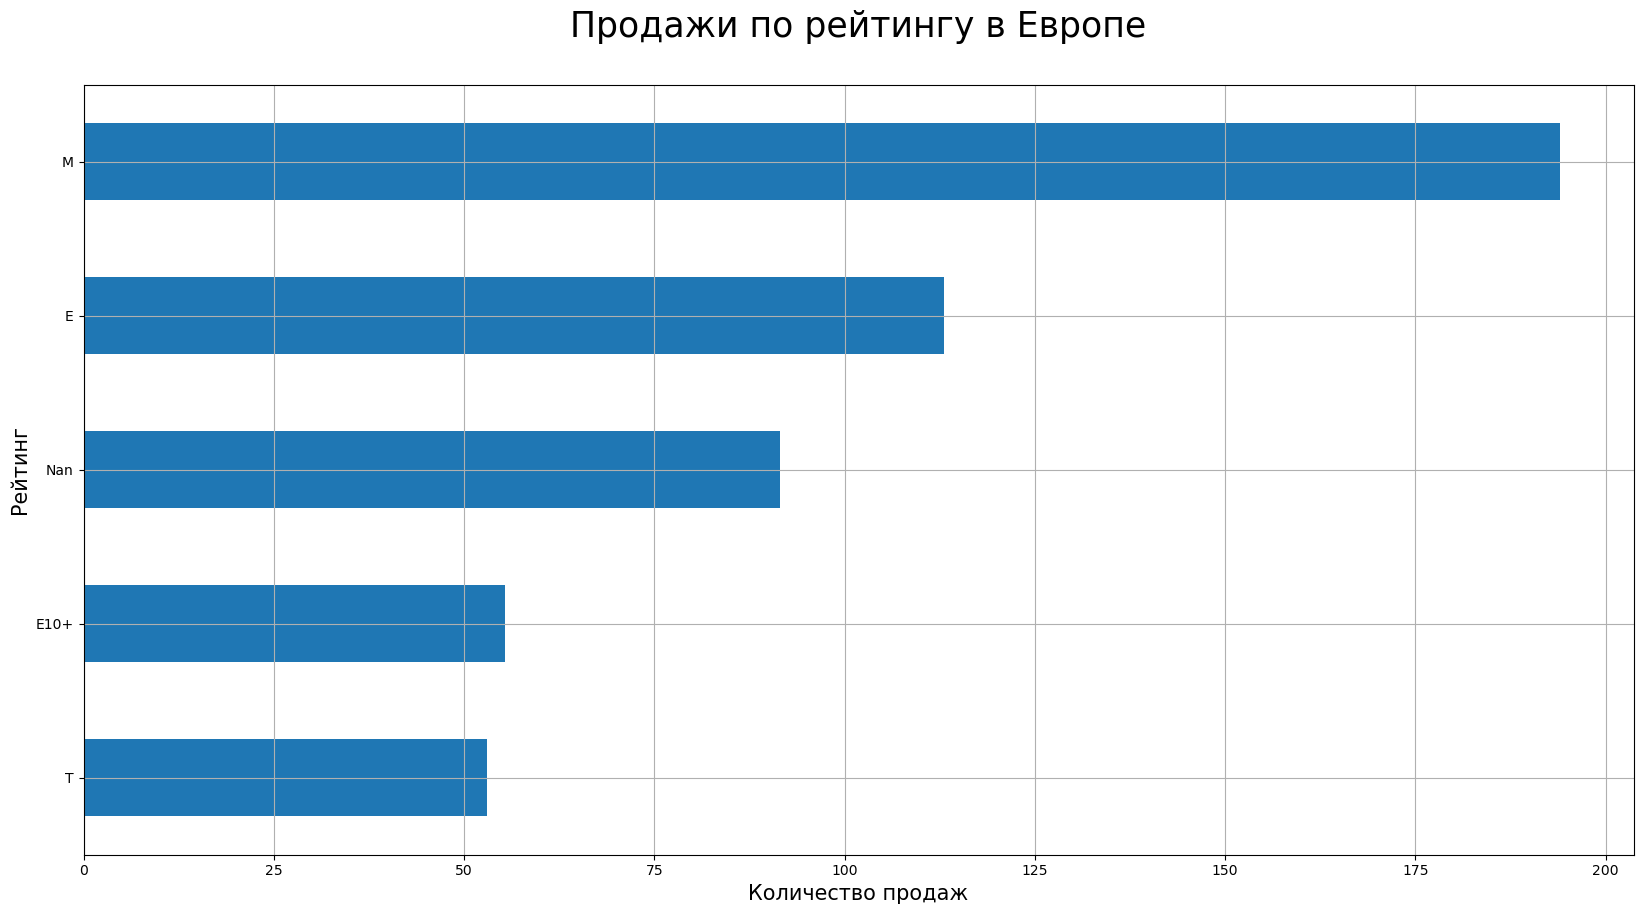

In [28]:
# создал сводную таблицу и построил по ней столбчатую диграмму
(
    current_period.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Продажи по рейтингу в Европе' + "\n", fontsize = 25)
);
plt.ylabel('Рейтинг', fontsize = 15);
plt.xlabel('Количество продаж', fontsize = 15);

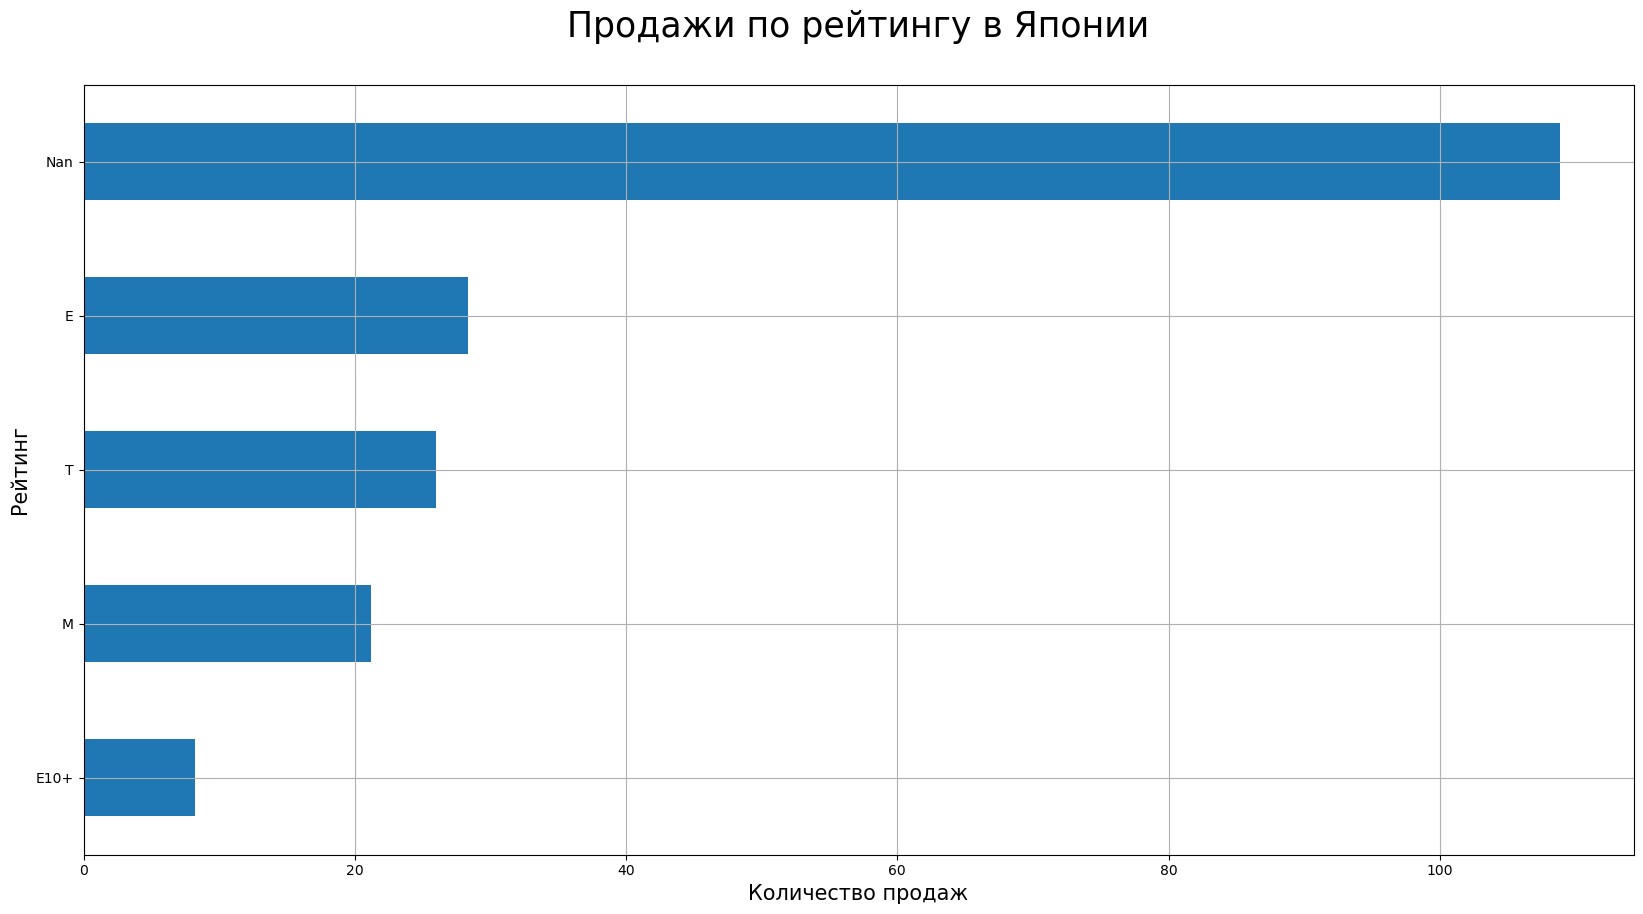

In [29]:
# создал сводную таблицу и построил по ней столбчатую диграмму
(
    current_period.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales')
    .plot(kind = 'barh', grid=True, figsize=(20, 10), legend=False)
    .set_title('Продажи по рейтингу в Японии' + "\n", fontsize = 25)
);
plt.ylabel('Рейтинг', fontsize = 15);
plt.xlabel('Количество продаж', fontsize = 15);

**Вывод:** так как рейтинг ESRB предназначен для маркировки игр для США и Канады, то в регионе Японии самое большое число продаж приходится на игры без рейтинга.

**Вывод раздела:** в ходе составления портрета пользователя было выявлено: самые популярные платформы и жанры для пользователей каждого региона, влияние рейтинга ESRB на продажи в отдельном регионе.

## Шаг 5. Проверка гипотез

### Первая гипотеза

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [34]:
score_xone = round(current_period.query('platform == "XOne" and not(user_score.isna())')['user_score'].mean(), 2)
score_pc = round(current_period.query('platform == "PC" and not(user_score.isna())')['user_score'].mean(), 2)
alpha = 0.05
Xbox_PC_test = st.ttest_ind(current_period.query('platform == "XOne" and not(user_score.isna())')['user_score']
                            , current_period.query('platform == "PC" and not(user_score.isna())')['user_score'])
print(f'p-value: {Xbox_PC_test.pvalue}')
if Xbox_PC_test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
print(f'Средний пользовательский рейтинг платформы Xbox One: {score_xone}, а PC: {score_pc}')

p-value: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу
Средний пользовательский рейтинг платформы Xbox One: 6.52, а PC: 6.43


**Вывод:** есть основания полагать, что действительно средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Вторая гипотеза

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые.  
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

In [32]:
score_action = round(current_period.query('genre == "Action" and not(user_score.isna())')['user_score'].mean(), 2)
score_sports = round(current_period.query('genre == "Sports" and not(user_score.isna())')['user_score'].mean(), 2)
alpha = 0.05
Action_Sports_test = st.ttest_ind(current_period.query('genre == "Action" and not(user_score.isna())')['user_score']
                            , current_period.query('genre == "Sports" and not(user_score.isna())')['user_score'])
print(f'p-value: {Action_Sports_test.pvalue}')
if Action_Sports_test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
print(f'Средний пользовательский рейтинг жанра Action: {score_action}, а Sports: {score_sports}')

p-value: 4.804523380462917e-26
Отвергаем нулевую гипотезу
Средний пользовательский рейтинг жанра Action: 6.83, а Sports: 5.46


**Вывод:** Небезосновательно утверждать, что действительно средние пользовательские рейтинги жанров Action и Sports разные.

**Вывод:** формулировка, как в первой, так и во второй нулевой гипотезе строилась на равенстве двух средних генеральных выборок, альтернативная на их различии. К выборкам применил t-критерий при тестировании гипотез, потому что эти две выборки независимые. 

## Выводы

В результате проведённого анализа, делаю следующие выоды:
- В данных присутствуют пропущенные значения, так же не все столбцы соответствуют нужному типу данных, с помощью отбора нужных столбцов были выявлены и удалены неявные дубликаты, было удалено некритичное число пустых значений в столбцах названия игры и года её выпуска, названия столбцов приведено к нижнему регистру, поставлены заглушки на пустые значения рейтинга, оставлены без изменений пустые оценки пользователей и критиков, добавлен новый столбец с суммой продаж регионов.  


- Было определено, что данные до 1994 года включительно являются незначительными. Наибольшие продажи у платформ: PS, DS, Wii, PS3, X360, PS2. Характерный срок для появления новой и исчезновения старой платформы составляет 6 лет. Актуальный период выбран с 2012 по 2016 года. **Далее все выводы выполнены по актульному периоду**. Лидируют по суммарным продажам такие платформы, как PS4, PS3. Проваливаются в продажах: DC, PSP. Потенциально прибыльные платформы: PS4, PS3, X360, 3DS и XOne. Крупные медианные глобальные продажи у платформ X360, Wii, PS4, XOne и WiiU. Взаимосвязь между оценками пользователей и числом продаж очень незкая, можно даже сказать что её нет, а критиков выше, но всё равно не слишком сильная. Тем не менее, число продаж зависит от оценок критиков, нежели оценкок пользователей. Самыми прибильными жанрами являются: Shooter, Sports и Platform, принимая во внимания, то что в этих жанрах выпущено не так много игр, например, как в Action и Role-Playing. Выделяется жанр Adventure, у которого досточно большое число выпущенных в нём игр, но продажи совсем маленькие.  


- В северной Америке рынок почти поровну делят платформы X360, PS4, PS3 и XOne. В Европе преобладает PS4, в меньшей степени PS3 и X360. В Японии около половиины занимает 3DS, на втором месте PS3. Что касается жанров, то в Северной Америке, как и в Европе самые популярные Action и Shooter. В Японии Role-Playing и Action. По причине того, что рейтинг ESRB предназначен для маркировки игр для США и Канады, то в регионе Япония самое большое число продаж приходится на игры без рейтинга.


- Есть основания полагать, что действительно средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Небезосновательно утверждать, что действительно средние пользовательские рейтинги жанров Action и Sports разные.

Существую определяющие успешность игры параметры. Она должна быть выпущена на платформы PS4, PS3 и XOne, в жанре Action с рейтингом M, с рекламой в регион Северной Америки. Также стоит обращать внимание на оценки критиков.